In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import sys
sys.path.append('../src')

In [177]:
from spaceoracle.models.estimators import GeoCNNEstimatorV2
from spaceoracle.tools.data import SpaceOracleDataset

In [178]:
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

In [326]:
adata = anndata.read_h5ad('../data/slideseq/day3_1.h5ad')
# adata = anndata.read_h5ad('../data/slideseq/day3_2.h5ad')

In [327]:
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [328]:
n_top_genes = 4000
min_cells = 10
min_counts = 350

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
sc.pp.filter_genes(adata, min_cells=min_cells)

adata.layers["raw_count"] = adata.X

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 9043 × 4000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [380]:
estimator = GeoCNNEstimatorV2(adata, target_gene='Cd74')

In [385]:
estimator.regulators = np.intersect1d(df.source.values, adata.var_names)

In [386]:
estimator.fit(
    annot='rctd_cluster', 
    max_epochs=150, 
    learning_rate=3e-4, 
    spatial_dim=64,
    mode='train_test',
    rotate_maps=False
)

[mps] MSE: 0.3288 | Baseline: 0.5301: 100%|██████████| 150/150 [12:30<00:00,  5.00s/it]

Best model at 102/150


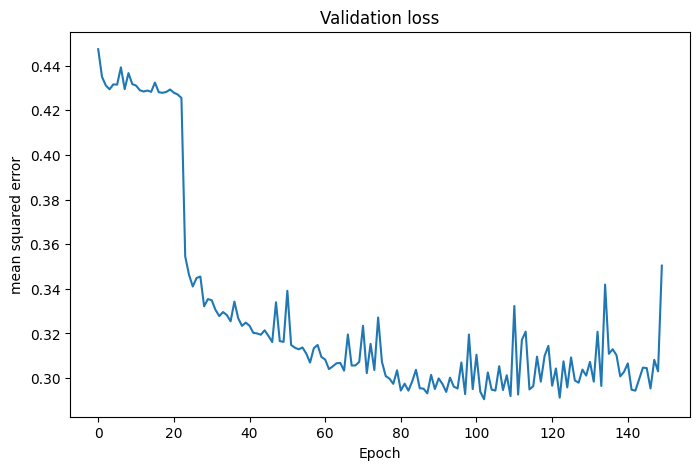

In [387]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title('Validation loss')
plt.show()

In [388]:
import numpy as np
import seaborn as sns

In [389]:
import pickle
with open('celloracle_links.pkl', 'rb') as f:
    celloracle_links = pickle.load(f)

celloracle_links.keys()

dict_keys(['B-cell', 'Cd8 T-cell', 'Tfh', 'Naive', 'Treg', 'Th1'])

In [390]:
df = (
    celloracle_links[celltypes[ct]]
        .query(f'target=="Cd74"')
        .reset_index(drop=True)
)

df['significant'] = df.p < 0.05

df

,source,target,coef_mean,coef_abs,p,-logp,significant
0,Pax5,Cd74,0.061311,0.061311,4.789383e-13,12.319720,True
1,Ebf1,Cd74,0.055598,0.055598,3.606950e-12,11.442860,True
2,Atf3,Cd74,-0.001121,0.001121,8.557307e-02,1.067663,False
3,Bcl11a,Cd74,0.060210,0.060210,5.237469e-12,11.280879,True
4,Egr2,Cd74,-0.022506,0.022506,2.676802e-08,7.572384,True
5,Stat2,Cd74,0.020885,0.020885,2.321459e-07,6.634239,True
6,Klf7,Cd74,-0.007943,0.007943,1.770694e-02,1.751857,True
7,Hivep1,Cd74,-0.005864,0.005864,9.815449e-03,2.008090,True
8,Rxra,Cd74,-0.013098,0.013098,4.709356e-04,3.327038,True
9,Taf1,Cd74,-0.017997,0.017997,2.228258e-09,8.652034,True


In [346]:
celltypes = {
    "0": "B-cell",
    "1": "Cd8 T-cell",
    "2": "Tfh",
    "3": "Naive",
    "4": "Tfh",
    "5": "Treg",
    "6": "Th1"
}

In [393]:
clusters = np.array([celltypes[str(x)] for x in adata.obs['rctd_cluster']])

In [394]:
beta_df = pd.DataFrame(
    np.zeros((len(clusters), len(estimator.regulators))), 
    columns=estimator.regulators)

for ct in celltypes.keys():
    links =(celloracle_links[celltypes[ct]]
        .query(
            f'target=="Cd74"')
        .reset_index(drop=True)
        .set_index('source').reindex(estimator.regulators).reset_index()
    )

    for tf in beta_df.columns:
        beta_df.loc[clusters == celltypes[ct], tf] = links.query(f'source == "{tf}"').coef_mean.values[0]

In [396]:
betas = beta_df.values

In [391]:
betas = estimator.get_betas(
    np.array(adata.obsm['spatial']),
    np.array(adata.obs['rctd_cluster']),
)

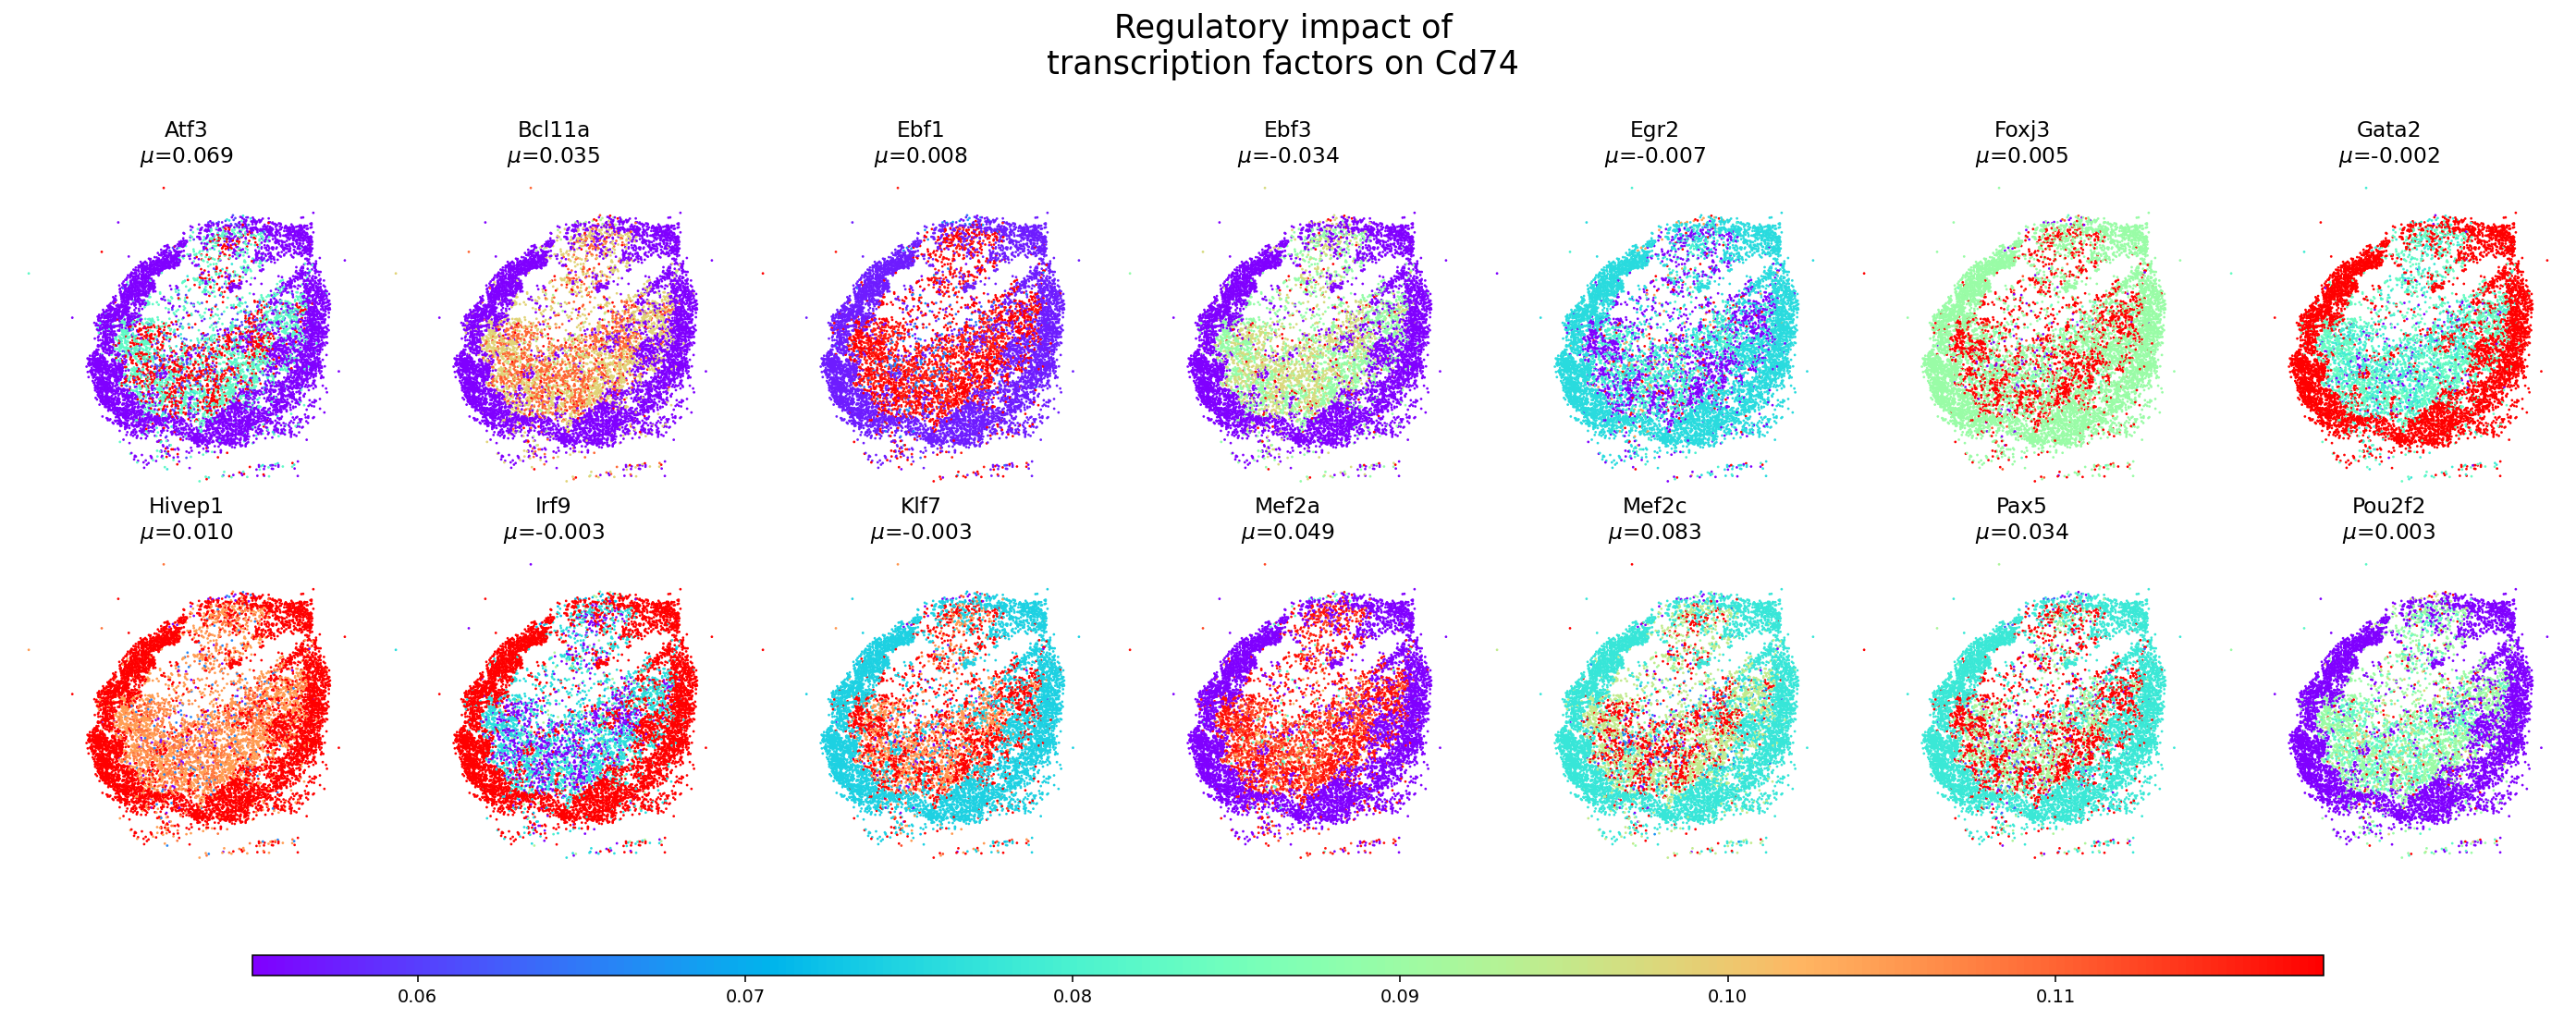

In [397]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata.obsm['spatial'][:, 0], y=adata.obsm['spatial'][:, 1], 
                s=2, c=betas[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

In [ ]:
model.predict_y(model.betas, adata.X)